# SandBox - Assignment2

This script is made only to see the effects of each processing step (centering,rereferencing,filtering) both on time and frequency domains

## Import libraries

In [1]:
import os
import pyxdf # xdf file importation
import matplotlib.pyplot as plt
import numpy as np
from my_functions import *
# library for creating filters
from scipy.signal import butter, iirnotch, filtfilt, welch
#%matplotlib widget

### Ensure that the root directory is the project directory
In some cases, the root directory may not be the project directory. This is usually the case when the notebook is run from a subdirectory of the project directory.

In [2]:
# if pwd is SRC  change to root
print("Current working directory: ", os.getcwd())
if os.path.basename(os.getcwd()) == "SRC":
    os.chdir("..")
print("Current working directory: ", os.getcwd())
print(os.path.basename(os.getcwd()))

Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio


In [3]:
plt.close("all")  # close all figure windows

## Initialization

### Generate a signal

Generation de deux signaux sinusoidaux de durée identique et dont l'amplitude varie a mi chemin.
L'amplitude du signal 1 commence à une amplitude de 1 (A.U) et diminue a 80% de l'amplitude initiale.
L'amplitude du signal 1 commence à une amplitude de 20 (A.U) et diminue a 50% de l'amplitude initiale.

In [4]:
Srate=500
length_time=20
change_time=length_time/2
signal_frequency1=12
signal_frequency2=20
original_amp=1
new_amp=original_amp/1000


times,signal_amplitudes1=generate_sine_wave(amplitude=original_amp, frequency=signal_frequency1, duration=length_time, 
                               change_time=change_time, new_amplitude=new_amp, sample_rate=Srate)
times2,signal_amplitudes2=generate_sine_wave(amplitude=20, frequency=signal_frequency2, duration=length_time, 
                               change_time=change_time, new_amplitude=10, sample_rate=Srate)

In [5]:
signal_electrodes=np.column_stack((signal_amplitudes1,signal_amplitudes2)) #stacking the signals electrodes 
print(signal_electrodes.shape)

(10000, 2)


### Electrode selector

In [6]:
ELECTRODE_NUM=1
SELECTOR=ELECTRODE_NUM-1 #Due to python indices

### Define markers

Creation d'une table de marqeurs representant le debut d'un evenement servant de reference au calcul des PSD. 
Le premier marqueur 111 correspond au changement d'amplitude des signaux.

In [7]:
marker_timestamps=np.array([(change_time-3,100),(change_time,111),(change_time+3,100),(change_time+6,111)])


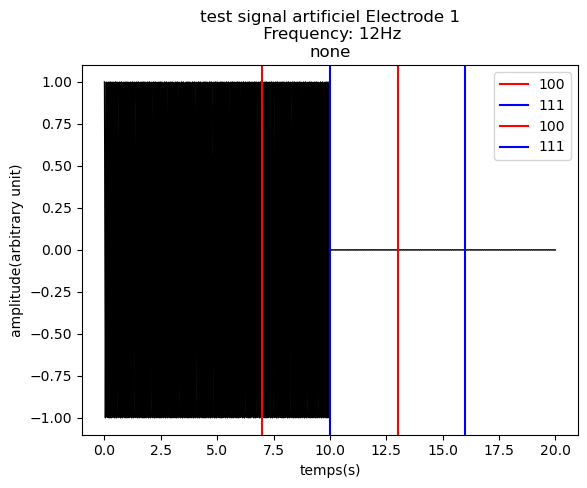

In [8]:
single_plot(filename="none",fig_number=1,x=times,y=signal_electrodes[:,SELECTOR],markers_times_array=marker_timestamps,
            fig_title="test signal artificiel Electrode "+str(ELECTRODE_NUM)+"\n Frequency: "+ str(eval("signal_frequency"+str(ELECTRODE_NUM)))+"Hz",
            xlabel="temps(s)",ylabel="amplitude(arbitrary unit)")

### Compute the signals PSD

In [9]:
nearest_marker_indices_timestamps = nearest_timestamps_array_finder(
    times, marker_timestamps)

MARKERS LEN: 4


In [10]:
time_window=1 # Segment length of the signal on which the PSD is computed (expressed in seconds)
tridi_freqs_before, tridi_Pxx_densities_before = compute_lagged_psd2_all_electrodes(signal_electrodes, Srate, nearest_marker_indices_timestamps,
                                                                                    time_lag=time_window, direction="before")

lower_end: 3000
Higher_end: 4000
segment coordinates before marker: ( 3000 ; 3500 ), delta_index: 500
segment coordinates after marker: ( 3500 ; 4000 ), delta_index: 500
lower_end: 4499
Higher_end: 5499
segment coordinates before marker: ( 4499 ; 4999 ), delta_index: 500
segment coordinates after marker: ( 4999 ; 5499 ), delta_index: 500
lower_end: 5999
Higher_end: 6999
segment coordinates before marker: ( 5999 ; 6499 ), delta_index: 500
segment coordinates after marker: ( 6499 ; 6999 ), delta_index: 500
lower_end: 7499
Higher_end: 8499
segment coordinates before marker: ( 7499 ; 7999 ), delta_index: 500
segment coordinates after marker: ( 7999 ; 8499 ), delta_index: 500
lower_end: 3000
Higher_end: 4000
segment coordinates before marker: ( 3000 ; 3500 ), delta_index: 500
segment coordinates after marker: ( 3500 ; 4000 ), delta_index: 500
lower_end: 4499
Higher_end: 5499
segment coordinates before marker: ( 4499 ; 4999 ), delta_index: 500
segment coordinates after marker: ( 4999 ; 5499 

In [11]:
tridi_freqs_after, tridi_Pxx_densities_after = compute_lagged_psd2_all_electrodes(signal_electrodes, Srate, nearest_marker_indices_timestamps,
                                                                                  time_lag=time_window, direction="after")

lower_end: 3000
Higher_end: 4000
segment coordinates before marker: ( 3000 ; 3500 ), delta_index: 500
segment coordinates after marker: ( 3500 ; 4000 ), delta_index: 500
lower_end: 4499
Higher_end: 5499
segment coordinates before marker: ( 4499 ; 4999 ), delta_index: 500
segment coordinates after marker: ( 4999 ; 5499 ), delta_index: 500
lower_end: 5999
Higher_end: 6999
segment coordinates before marker: ( 5999 ; 6499 ), delta_index: 500
segment coordinates after marker: ( 6499 ; 6999 ), delta_index: 500
lower_end: 7499
Higher_end: 8499
segment coordinates before marker: ( 7499 ; 7999 ), delta_index: 500
segment coordinates after marker: ( 7999 ; 8499 ), delta_index: 500
lower_end: 3000
Higher_end: 4000
segment coordinates before marker: ( 3000 ; 3500 ), delta_index: 500
segment coordinates after marker: ( 3500 ; 4000 ), delta_index: 500
lower_end: 4499
Higher_end: 5499
segment coordinates before marker: ( 4499 ; 4999 ), delta_index: 500
segment coordinates after marker: ( 4999 ; 5499 

In [12]:
# separation of the markers of each 3d array (before and after)
tridi_Pxx_densities_111_before = tridi_Pxx_densities_before[:, 1::2, :]
tridi_Pxx_densities_111_after = tridi_Pxx_densities_after[:, 1::2, :]

tridi_Pxx_densities_100_before = tridi_Pxx_densities_before[:, 0::2, :]
tridi_Pxx_densities_100_after = tridi_Pxx_densities_after[:, 0::2, :]

In [13]:
# compute the ratio of the Pxx_densities of each side of each marker(12*2) of each of the 8 channel
# need (PSDafter-PSDbefore/PSDbefore)*100
tridi_Pxx_densities_ratio_111 = ((
    tridi_Pxx_densities_111_after-tridi_Pxx_densities_111_before)/tridi_Pxx_densities_111_before)*100
tridi_Pxx_densities_ratio_100 = ((
    tridi_Pxx_densities_100_before-tridi_Pxx_densities_111_after)/tridi_Pxx_densities_111_after)*100

if np.array_equal(tridi_freqs_after,tridi_freqs_before) :
    tridi_freqs_ratio=tridi_freqs_after

### Plot the PSDs

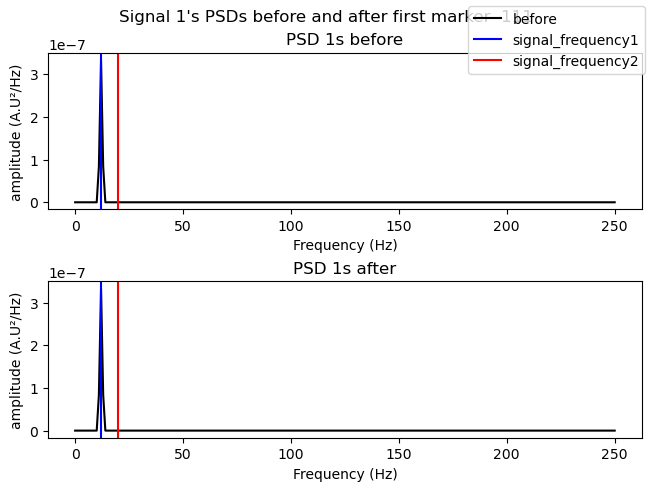

In [14]:
figure,axis=plt.subplots(2,num=2,layout="constrained")
figure.suptitle("Signal "+str(ELECTRODE_NUM)+"'s PSDs before and after first marker  111")
axis[0].set_title("PSD "+str(time_window) +"s before")
axis[0].set_ylabel("amplitude (A.U²/Hz)")
axis[0].set_xlabel("Frequency (Hz)")
axis[0].plot(tridi_freqs_ratio[:, 0, SELECTOR],tridi_Pxx_densities_111_before[:, 1, 0],color="black",label="before")

axis[0].axvline(x=signal_frequency1,color="b",label="signal_frequency1")
axis[0].axvline(x=signal_frequency2,color="r",label="signal_frequency2")

axis[1].set_title("PSD "+str(time_window) +"s after")
axis[1].set_ylabel("amplitude (A.U²/Hz)")
axis[1].set_xlabel("Frequency (Hz)")
axis[1].plot(tridi_freqs_ratio[:, 0, SELECTOR],tridi_Pxx_densities_111_after[:, 1, 0],color="black")
axis[1].axvline(x=signal_frequency1,color="b",label="_signal_frequency1")
axis[1].axvline(x=signal_frequency2,color="r",label="_signal_frequency2")

figure.legend()


### Plot the electrode i's first marker ERSP over specific time window 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


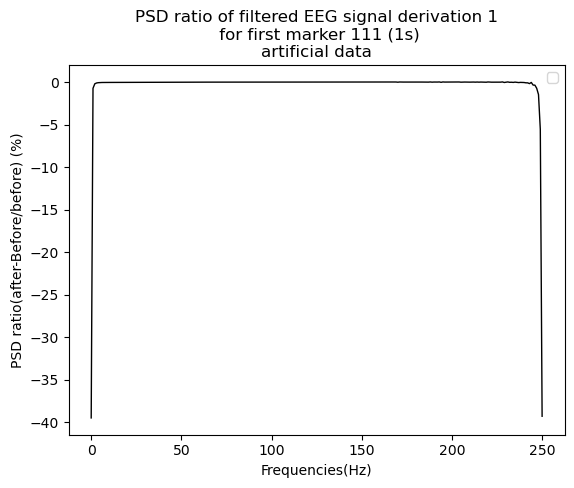

In [15]:
single_plot("artificial data", fig_number=3, x=tridi_freqs_ratio[:, 0, SELECTOR], y=tridi_Pxx_densities_ratio_111[:, 1, SELECTOR],
            fig_title="PSD ratio of filtered EEG signal derivation " +
            str(1)+
            "\n for first marker 111 ("+str(time_window)+"s)",
            xlabel="Frequencies(Hz)", ylabel="PSD ratio(after-Before/before) (%)")

In [16]:
for i in range(0,len(tridi_Pxx_densities_111_after)):
    a=tridi_Pxx_densities_111_after[i,0,0]
    b=tridi_Pxx_densities_111_before[i,0,0]
    r=((a-b)/b)*100
    z=tridi_Pxx_densities_ratio_111[i,0,0]
    if z!=r:
        break
    print("for",str(i), "r and z are equal")
print("not equal")


"""print(a)
print(b)
print(r)
print(z)"""

for 0 r and z are equal
for 1 r and z are equal
for 2 r and z are equal
for 3 r and z are equal
for 4 r and z are equal
for 5 r and z are equal
for 6 r and z are equal
for 7 r and z are equal
for 8 r and z are equal
for 9 r and z are equal
for 10 r and z are equal
for 11 r and z are equal
for 12 r and z are equal
for 13 r and z are equal
for 14 r and z are equal
for 15 r and z are equal
for 16 r and z are equal
for 17 r and z are equal
for 18 r and z are equal
for 19 r and z are equal
for 20 r and z are equal
for 21 r and z are equal
for 22 r and z are equal
for 23 r and z are equal
for 24 r and z are equal
for 25 r and z are equal
for 26 r and z are equal
for 27 r and z are equal
for 28 r and z are equal
for 29 r and z are equal
for 30 r and z are equal
for 31 r and z are equal
for 32 r and z are equal
for 33 r and z are equal
for 34 r and z are equal
for 35 r and z are equal
for 36 r and z are equal
for 37 r and z are equal
for 38 r and z are equal
for 39 r and z are equal
for 40 r a

'print(a)\nprint(b)\nprint(r)\nprint(z)'

Conclusion: Probleme données ratio reproduit. Persistant sur signal artificiel. Les PSD sont coherentes avec les caracteristiques des signaux generés.

Causes possibles: 
1. Elementwise operation: ecartée car fonctionne en soustraction (et syntaxe correcte)
2. Separation des matrices marqueurs 111 et 100, avant et apres: mauvaise selection?
3. Bug de la fonction nearest_timestamps_array_finder() qui associe a chaque temps de marqueur le temps le plus proche correspondant a un echantillion dans le signal.